In [1]:
import logging
logging.getLogger("matplotlib").setLevel(logging.INFO)
import math
import os
from pathlib import Path

from huggingface_hub import snapshot_download
%matplotlib inline
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("white")
from sklearn.metrics import roc_auc_score, roc_curve
import SimpleITK as sitk
import torch
import torchvision
torchvision.disable_beta_transforms_warning()
from tqdm.auto import tqdm

from experiment_config import config
from dataloader import get_data_loader
from finetune import make_weights_for_balanced_classes

torch.manual_seed(config.SEED)

current_dir = Path(os.getcwd())
workspace_root = current_dir.parent

annotations_csv_path = Path(f"/{workspace_root}/LUNA25_Public_Training_Development_Data.csv")
# the folder containing the 5-fold predictions, either separate files in 5 subfolders (after training) or a single file ("all_folds_predictions.csv")
predictions_dir = Path(f"/{workspace_root}/hiera-luna25-finetuning/results/finetune-hieral-3D-20250729")
predictions_csv_path = predictions_dir / "all_folds_predictions.csv"
# the folder to save plots and statistics
figures_dir = Path(f"/{workspace_root}/figures")
figures_dir.mkdir(exist_ok=True)
# the following folders and files will be downloaded and/or created if non-existing; don't change
dataset_dir = Path(f"/{workspace_root}/LUNA25-MedSAM2")
segmentations_dir = dataset_dir / "instance-labels"
volumes_csv_path = Path(f"/{workspace_root}/mask_volumes.csv")

# Download

In [2]:
# https://huggingface.co/datasets/wanglab/LUNA25-MedSAM2
if not dataset_dir.exists():
    local_path = snapshot_download(
      repo_id="wanglab/LUNA25-MedSAM2",
      repo_type="dataset",
      local_dir=dataset_dir
    )
print(f"Segmentations are avaialble at {segmentations_dir}")

Segmentations are avaialble at //workspace/LUNA25-MedSAM2/instance-labels


# Analyze

## Nodule Volumes

In [3]:
def calculate_mask_volumes(folder_path):
    """
    Calculates the volume (in mm^3) of segmentation masks in NIfTI files
    within a given folder and stores the results in a DataFrame.

    Assumes the files are named logically (e.g., ending with .nii.gz).
    The volume is calculated by counting non-zero voxels and multiplying
    by the volume of a single voxel (determined from the image's spacing).

    Args:
        folder_path (str or Path): The path to the folder containing .nii.gz files.

    Returns:
        pd.DataFrame: A DataFrame with columns "filename" and "volume_mm3".
                      Returns None if no .nii.gz files are found.
    """
    folder_path = Path(folder_path)
    nii_files = list(folder_path.glob("*.nii.gz"))
    if not nii_files:
        print(f"No .nii.gz files found in the folder {folder_path}")
        return None

    results = []
    for file_path in tqdm(nii_files):
        filename = file_path.name
        try:
            image = sitk.ReadImage(str(file_path))
            data = sitk.GetArrayFromImage(image)
            voxel_spacing = image.GetSpacing()

            if np.any(np.array(voxel_spacing) <= 0):
                print(f"Warning: Invalid voxel dimensions {voxel_spacing} found in {filename}. Skipping file.")
                results.append({"filename": filename, "volume_mm3": np.nan})
                continue

            voxel_volume_mm3 = np.prod(voxel_spacing)
            num_mask_voxels = np.count_nonzero(data)
            if num_mask_voxels == 0:
                print(f"Warning: File '{filename}' has 0 non-zero mask voxels.")
            total_volume_mm3 = num_mask_voxels * voxel_volume_mm3
            results.append({"filename": filename, "volume_mm3": total_volume_mm3})
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
            results.append({"filename": filename, "volume_mm3": np.nan})

    df_results = pd.DataFrame(results)
    return df_results

if not volumes_csv_path.exists():
    df_volumes = calculate_mask_volumes(segmentations_dir)
    if df_volumes is not None:
        df_volumes.to_csv(volumes_csv_path, index=False)
print(f"Mask volumes are avaialble at {volumes_csv_path}")

Mask volumes are avaialble at //workspace/mask_volumes.csv


In [4]:
df_volumes = pd.read_csv(volumes_csv_path)
df_annotations = pd.read_csv(annotations_csv_path)
df_volumes["SeriesInstanceUID"] = df_volumes["filename"].str.replace(".nii.gz", "", regex=False)
df_volumes["volume_percentile"] = df_volumes["volume_mm3"].rank(pct=True, method="average").round(4)
df_volumes["sphere_radius_mm"] = ((3 * df_volumes["volume_mm3"]) / (4 * math.pi)) ** (1/3)
df_annotations_volumes = pd.merge(df_annotations, df_volumes, on="SeriesInstanceUID", how="left")
df_annotations_volumes.drop(["filename"], axis=1, inplace=True)
display(df_annotations_volumes.head())
df_annotations_volumes[["volume_mm3", "sphere_radius_mm"]].describe()

PatientID                                  SeriesInstanceUID  StudyDate  \
0     100570  1.2.840.113654.2.55.32380467633296345717423514...   19990102   
1     106364  1.2.840.113654.2.55.16930993607533226779708566...   19990102   
2     127302  1.2.840.113654.2.55.13728437630416839550344528...   20000102   
3     128899  1.2.840.113654.2.55.40415300708683206534849072...   20010102   
4     215816  1.3.6.1.4.1.14519.5.2.1.7009.9004.241362276021...   19990102   

   CoordX  CoordY  CoordZ  LesionID       AnnotationID  NoduleID  label  \
0   61.14 -163.28 -177.75         1  100570_1_19990102  100570_1      1   
1   30.64  -95.96 -128.59         1  106364_1_19990102  106364_1      1   
2  -82.53  -27.85 -209.46         1  127302_1_20000102  127302_1      1   
3  -38.69   -8.78  -39.43         1  128899_1_20010102  128899_1      1   
4   32.89  -37.98 -100.04         1  215816_1_19990102  215816_1      1   

   Age_at_StudyDate  Gender   volume_mm3  volume_percentile  sphere_radius_mm  
0                63    Male  5504.687500             0.9422         10.953377  
1                67  Female   690.069580             0.7407          5.481946  
2                61    Male  1799.560547             0.8653          7.545580  
3                64    Male   393.610663             0.6323          4.546314  
4                69  Female  1584.692806             0.8533          7.232451

volume_mm3  sphere_radius_mm
count    6163.000000       6163.000000
mean     1941.455763          5.199384
std      8734.986932          3.503231
min         5.234299          1.077101
25%       128.398544          3.129612
50%       305.519897          4.178146
75%       847.329849          5.870222
max    241810.113309         38.648142

### Volume vs Label

Histogram saved to //workspace/figures/volume_mm3_by_label_all_folds.png


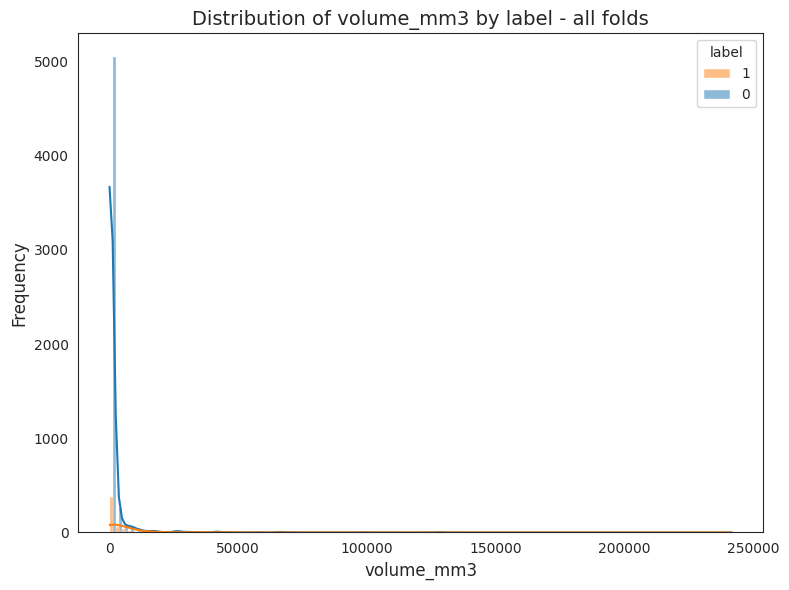

Histogram saved to //workspace/figures/top_95th_percentile_volume_mm3_by_label_all_folds.png


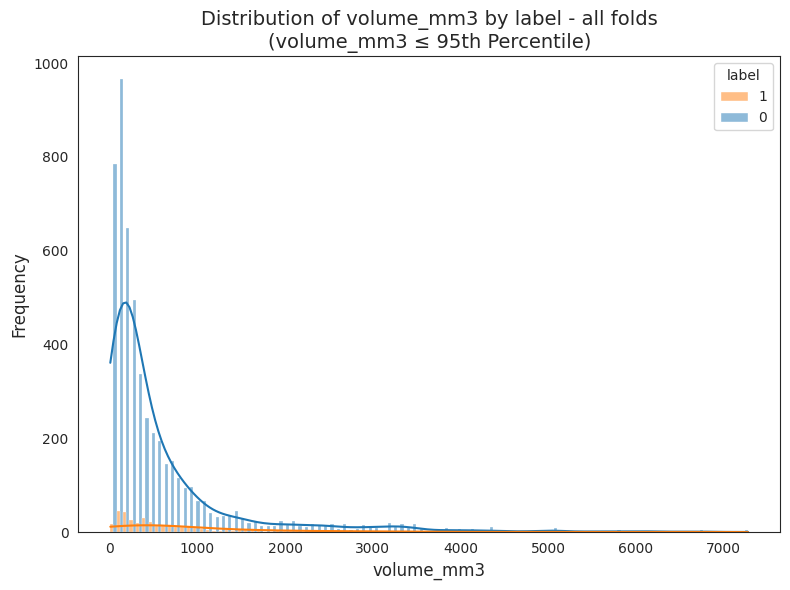

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_all_folds.png


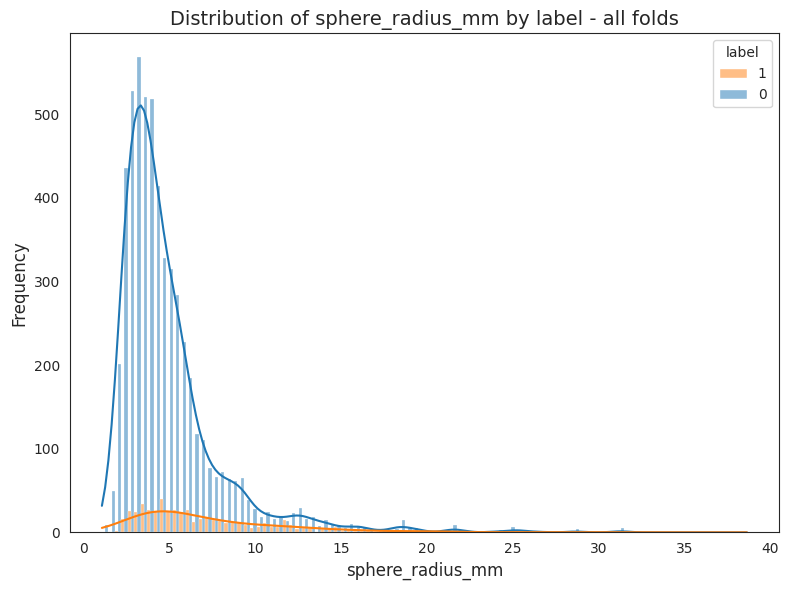

Histogram saved to //workspace/figures/top_95th_percentile_sphere_radius_mm_by_label_all_folds.png


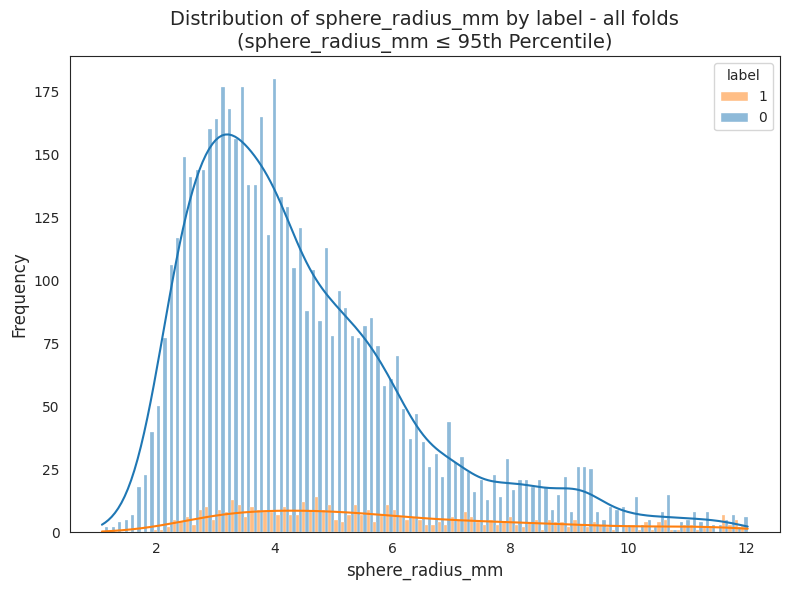

In [5]:
def plot_histogram_by_column(df, column_to_plot="volume_mm3", column_to_label="label", use_top_95th_percentile=False, plot_label="all folds", bins=100, save_plot=True):
    """
    Creates a histogram of the target column separated by another column.

    Args:
        df (pd.DataFrame): The DataFrame containing `column_to_plot` and `column_to_label`.
        column_to_plot (str, optional): The column to plot. Defaults to "volume_mm3".
        column_to_label (str, optional): The column to seperate the data by. Defaults to "label".
        use_top_95th_percentile (bool, optional): Whether to plot only the top 95th percentile of the data. Defaults to False.
        plot_label (str, optional): The label of the plot. Defaults to "all folds".
        bins (int, optional): Number of bins to use in the histogram. Defaults to 100.
        output_path (str or Path, optional): Path to save the plot.
    """
    plt.figure(figsize=(8, 6))

    df_plot = df.copy()
    df_plot[column_to_label] = df_plot[column_to_label].astype(str)

    if use_top_95th_percentile:
        column_95th_percentile = df_plot[column_to_plot].quantile(0.95)
        df_plot = df_plot[df_plot[column_to_plot] <= column_95th_percentile]

    default_palette = sns.color_palette()
    labels = sorted(df_plot[column_to_label].unique())
    color_mapping = {label: default_palette[i % len(default_palette)] for i, label in enumerate(labels)}

    sns.histplot(
        data=df_plot,
        x=column_to_plot,
        hue=column_to_label,
        palette=color_mapping,
        bins=bins,
        kde=True,
        multiple="dodge"
    )

    title = f"Distribution of {column_to_plot} by {column_to_label} - {plot_label}"
    if use_top_95th_percentile:
        title += f"\n({column_to_plot} ≤ 95th Percentile)"
    plt.title(title, fontsize=14)
    plt.xlabel(column_to_plot, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

    plt.tight_layout()
    if save_plot:
        save_name = f"{column_to_plot}_by_{column_to_label}_{plot_label.replace(' ', '_')}.png"
        if use_top_95th_percentile:
            save_name = "top_95th_percentile_" + save_name
        save_path = figures_dir / save_name
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Histogram saved to {save_path}")
    plt.show()

plot_histogram_by_column(df_annotations_volumes)
plot_histogram_by_column(df_annotations_volumes, use_top_95th_percentile=True)
plot_histogram_by_column(df_annotations_volumes, column_to_plot="sphere_radius_mm")
plot_histogram_by_column(df_annotations_volumes, column_to_plot="sphere_radius_mm", use_top_95th_percentile=True)

## Predictions

In [6]:
if not predictions_csv_path.exists():
    df_predictions = pd.DataFrame()
    for fold in range(1, 6):
        fold_preds_csv_path = predictions_dir / f"fold_{fold}" / "predictions.csv"
        df_fold_preds = pd.read_csv(fold_preds_csv_path)
        df_fold_preds["fold"] = fold
        df_predictions = pd.concat([df_predictions, df_fold_preds])
    df_predictions.to_csv(predictions_csv_path, index=False)
print(f"Predictions are avaialble at {predictions_csv_path}")

Predictions are avaialble at //workspace/hiera-luna25-finetuning/results/finetune-hieral-3D-20250729/all_folds_predictions.csv


In [7]:
df_predictions = pd.read_csv(predictions_csv_path)
df_annotations_volumes_predictions = pd.merge(df_annotations_volumes, df_predictions, on="AnnotationID", how="left")
labels_match = df_annotations_volumes_predictions["label_x"] == df_annotations_volumes_predictions["label_y"]
if labels_match.all():
    df_annotations_volumes_predictions.drop(["label_y"], axis=1, inplace=True)
    df_annotations_volumes_predictions.rename(columns={"label_x": "label"}, inplace=True)
    df_annotations_volumes_predictions["absolute_error"] = abs(df_annotations_volumes_predictions["probability"] - df_annotations_volumes_predictions["label"])
    df_annotations_volumes_predictions.sort_values(by=["absolute_error"], inplace=True, ascending=False)
    display(df_annotations_volumes_predictions.head())
else:
    print(f"Error: Labels in annotations and predictions are not the same!")

PatientID                                  SeriesInstanceUID  StudyDate  \
3713     209297  1.3.6.1.4.1.14519.5.2.1.7009.9004.281053541839...   20000102   
1634     210717  1.3.6.1.4.1.14519.5.2.1.7009.9004.136944259568...   19990102   
1637     210717  1.3.6.1.4.1.14519.5.2.1.7009.9004.113485382374...   20000102   
1955     211637  1.3.6.1.4.1.14519.5.2.1.7009.9004.275118133339...   20000102   
2546     201828  1.3.6.1.4.1.14519.5.2.1.7009.9004.123276122653...   20010102   

          CoordX      CoordY   CoordZ  LesionID       AnnotationID  NoduleID  \
3713 -101.330376   60.959396  -211.25         1  209297_1_20000102  209297_1   
1634   95.300000 -130.150000   -69.13         4  210717_4_19990102  210717_4   
1637   79.250000 -122.490000   -70.78         4  210717_4_20000102  210717_4   
1955   23.000000  132.250000  1730.06         3  211637_3_20000102  211637_3   
2546  -61.770000  -25.290000  -141.07         1  201828_1_20010102  201828_1   

      label  Age_at_StudyDate  Gender    volume_mm3  volume_percentile  \
3713      1                69  Female     79.562534             0.1986   
1634      0                71    Male  98847.419256             0.9980   
1637      0                72    Male  70436.813298             0.9973   
1955      0                60    Male  58314.321786             0.9958   
2546      1                63    Male    421.575322             0.6456   

      sphere_radius_mm  probability  fold  absolute_error  
3713          2.668128     0.082721     3        0.917279  
1634         28.683066     0.904832     5        0.904832  
1637         25.619483     0.904760     5        0.904760  
1955         24.056302     0.904605     3        0.904605  
2546          4.651527     0.095522     3        0.904478

### WeightedRandomSampler

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_train_set_in_fold_1.png


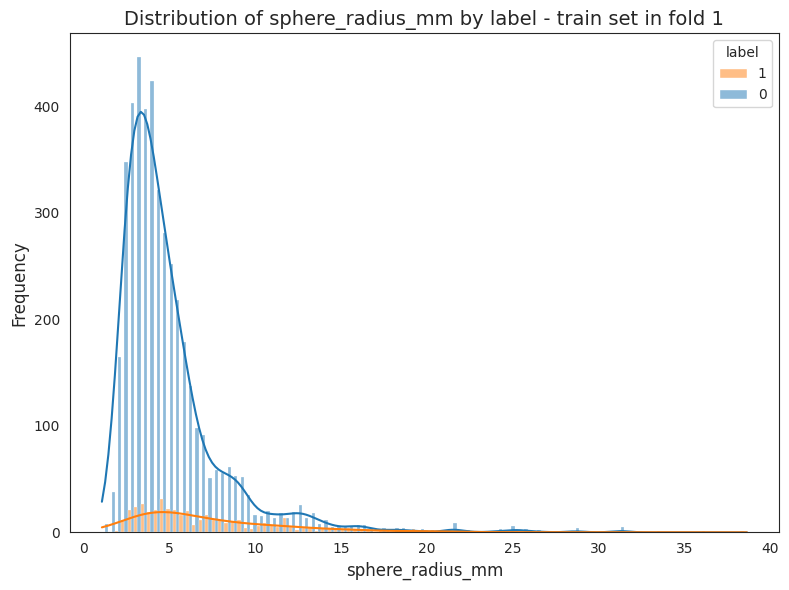

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_train_set_in_fold_1_after_sampling.png


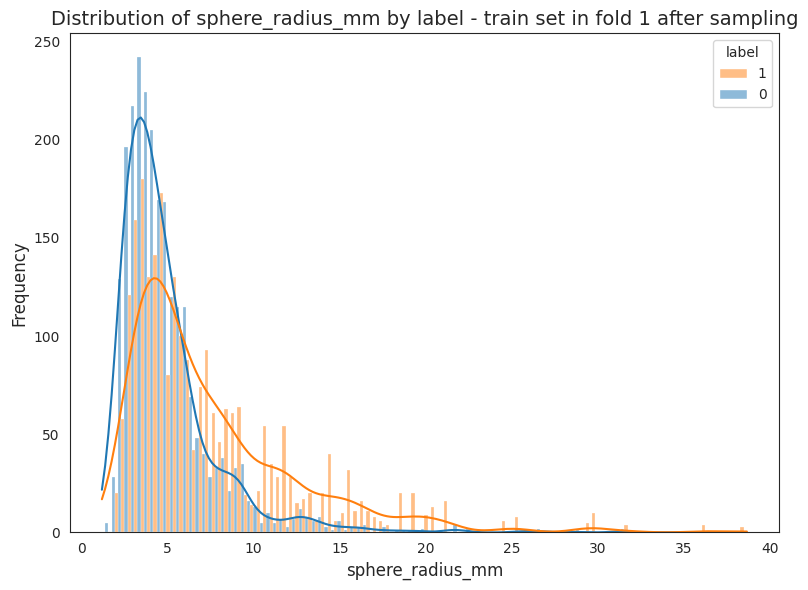

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_train_set_in_fold_2.png


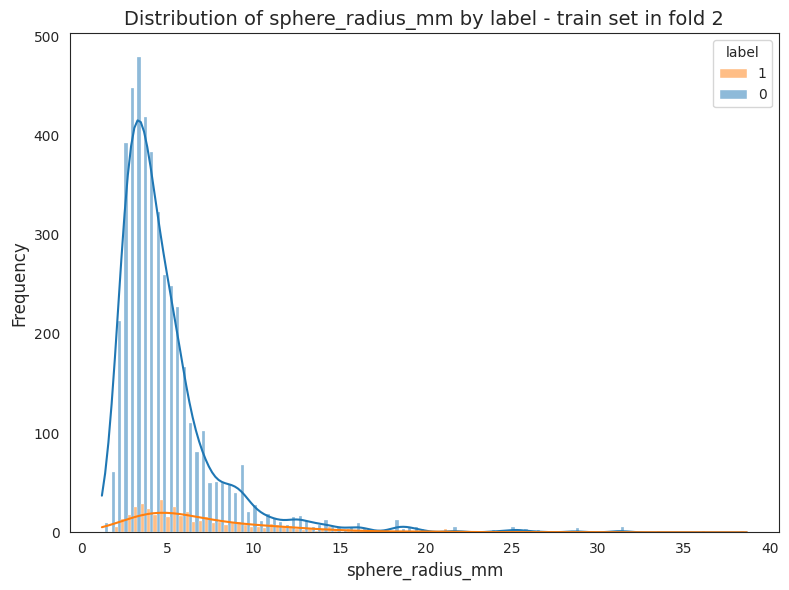

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_train_set_in_fold_2_after_sampling.png


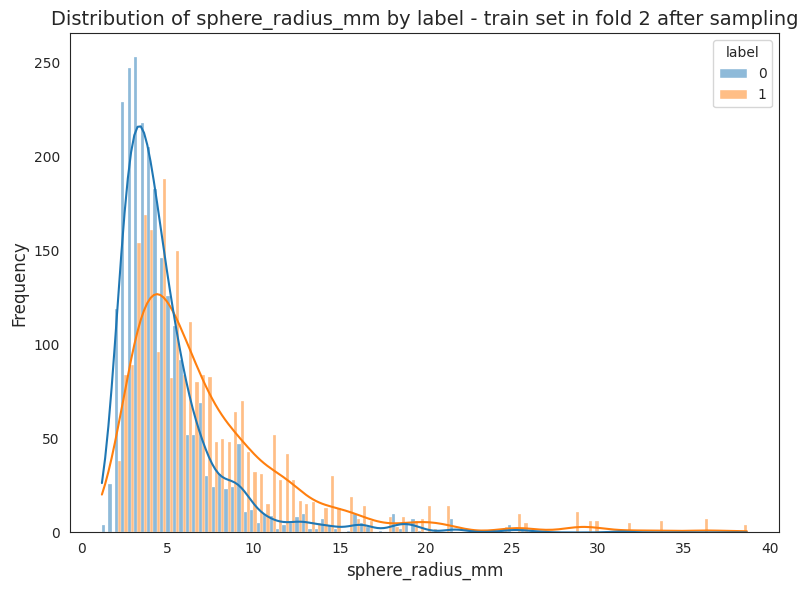

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_train_set_in_fold_3.png


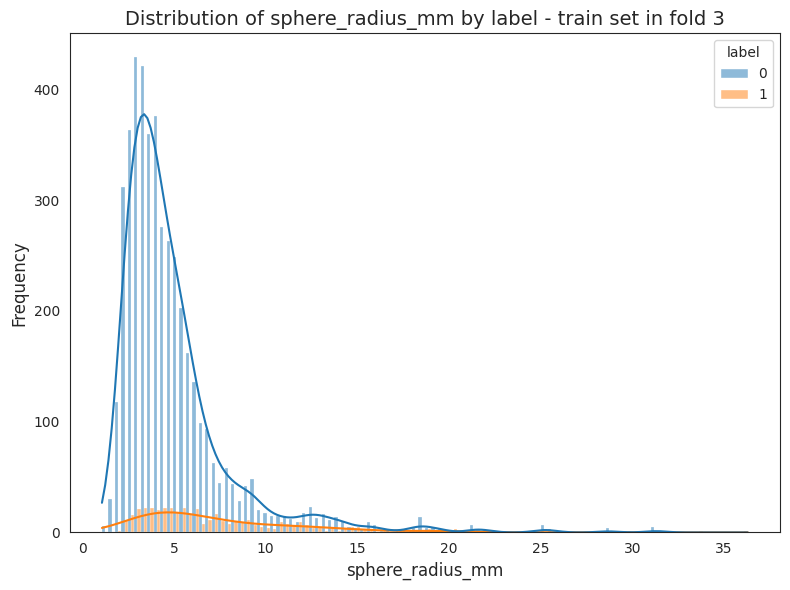

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_train_set_in_fold_3_after_sampling.png


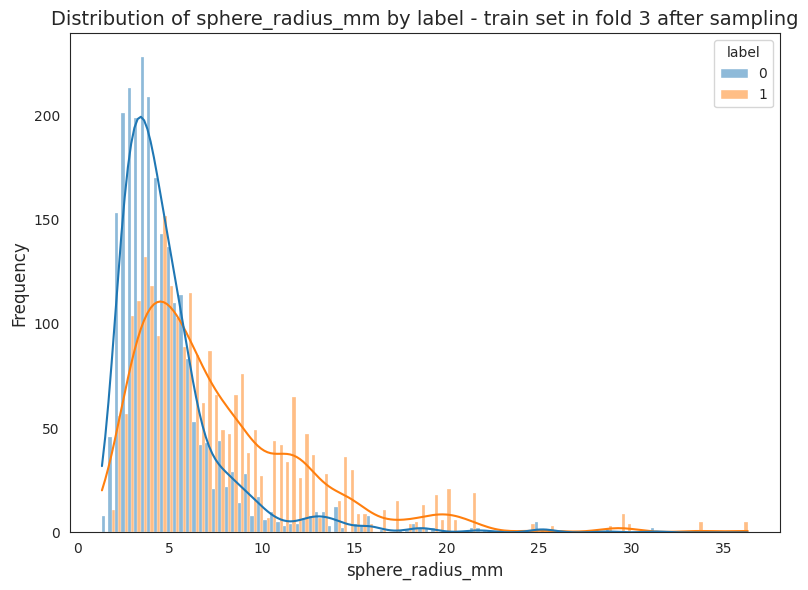

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_train_set_in_fold_4.png


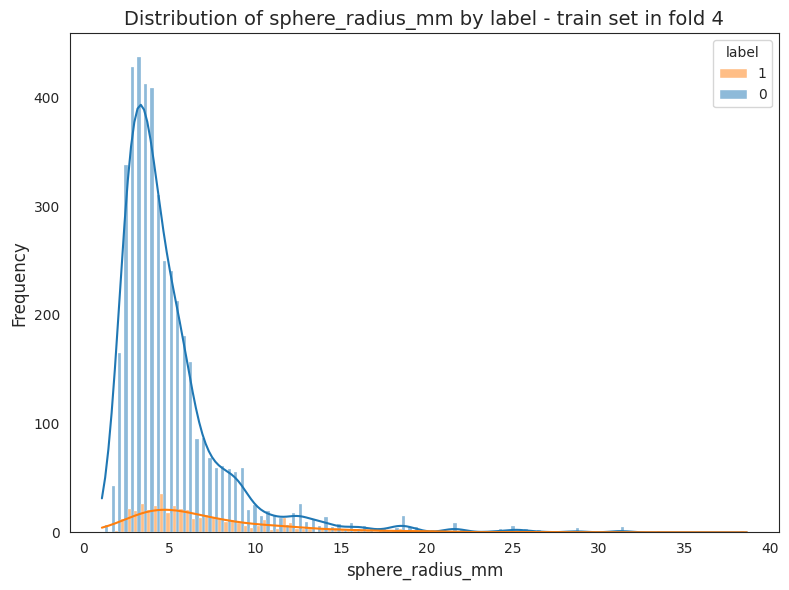

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_train_set_in_fold_4_after_sampling.png


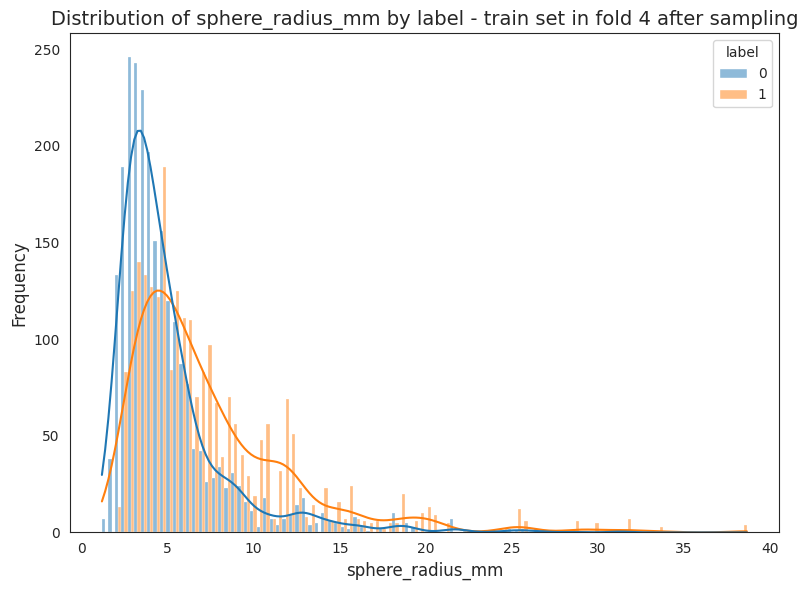

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_train_set_in_fold_5.png


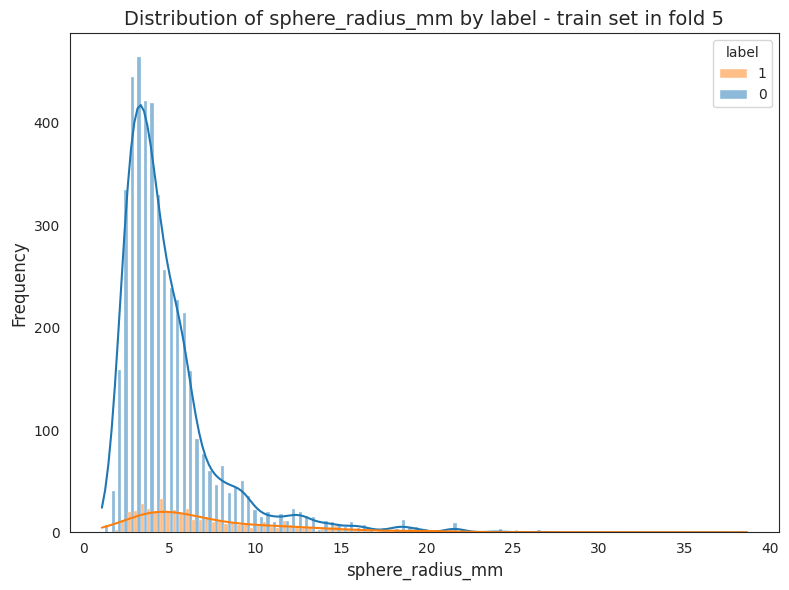

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_train_set_in_fold_5_after_sampling.png


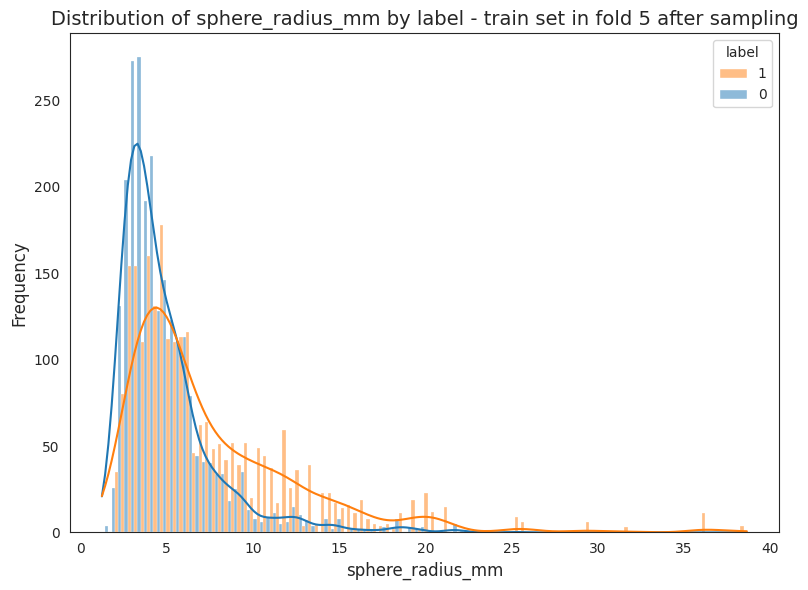

Histogram saved to //workspace/figures/sphere_radius_mm_by_label_all_folds_after_sampling.png


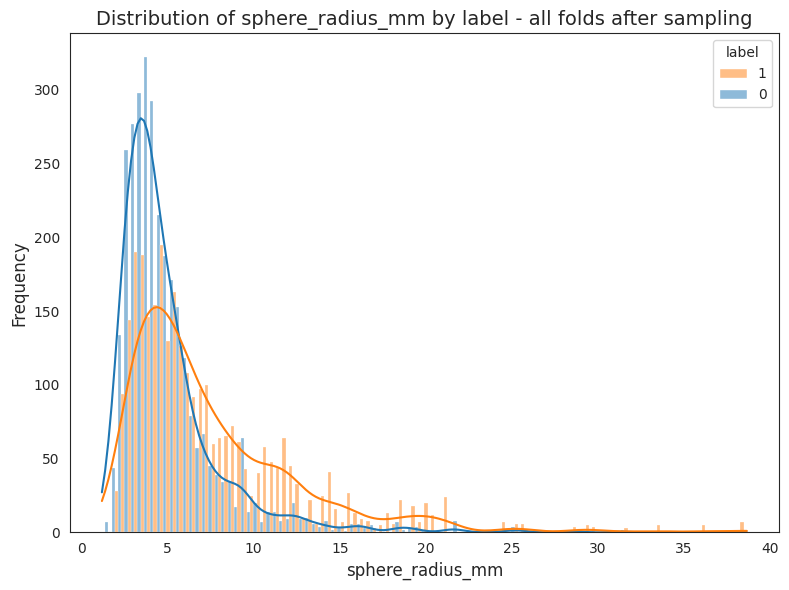

In [8]:
def plot_weighted_sampling_effect(df, plot_label):
    df_plot = df.copy()
    weights = make_weights_for_balanced_classes(df_plot["label"].values)
    weights = torch.DoubleTensor(weights)
    # note that this is not to reproduce the samples at finetuning time, but show the effect of sampling
    sampler = torch.utils.data.WeightedRandomSampler(weights=weights, num_samples=len(df_plot))
    sampled_indices = list(sampler)
    df_balanced = df_plot.iloc[sampled_indices].reset_index(drop=True)
    plot_histogram_by_column(df_balanced, column_to_plot="sphere_radius_mm", use_top_95th_percentile=False, plot_label=plot_label)

for fold in range(1, 6):
    df_val = df_annotations_volumes_predictions[df_annotations_volumes_predictions["fold"] == fold]
    df_val_annotation_ids = df_val["AnnotationID"].values
    df_train = df_annotations_volumes_predictions[~df_annotations_volumes_predictions["AnnotationID"].isin(df_val_annotation_ids)]
    plot_histogram_by_column(df_train, column_to_plot="sphere_radius_mm", use_top_95th_percentile=False, plot_label=f"train set in fold {fold}")
    plot_weighted_sampling_effect(df_train, plot_label=f"train set in fold {fold} after sampling")

plot_weighted_sampling_effect(df_annotations_volumes_predictions, plot_label="all folds after sampling")

### Volume vs Absolute Error

Scatterplot saved to //workspace/figures/error_volume_scatterplot_all_folds.png


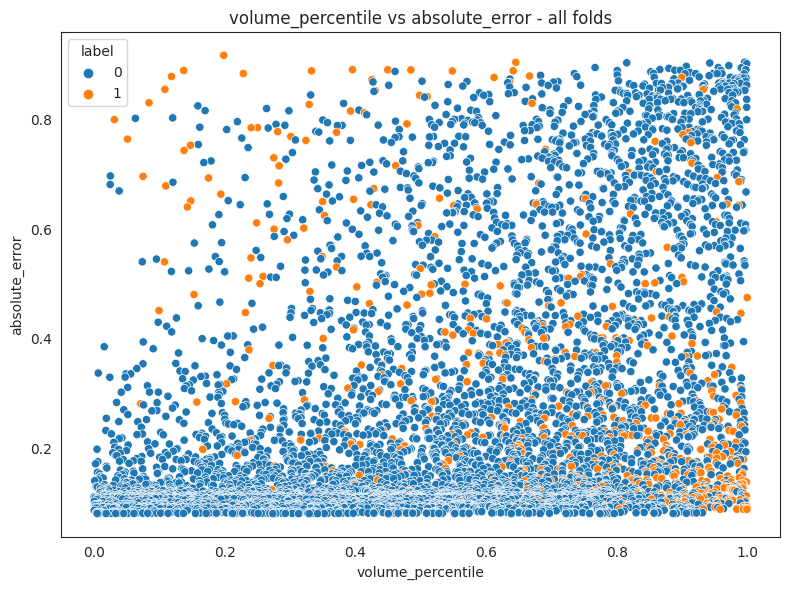

Scatterplot saved to //workspace/figures/error_volume_scatterplot_500_worst_predictions_in_all_folds.png
Worst predictions saved to //workspace/figures/500_worst_predictions_in_all_folds.csv


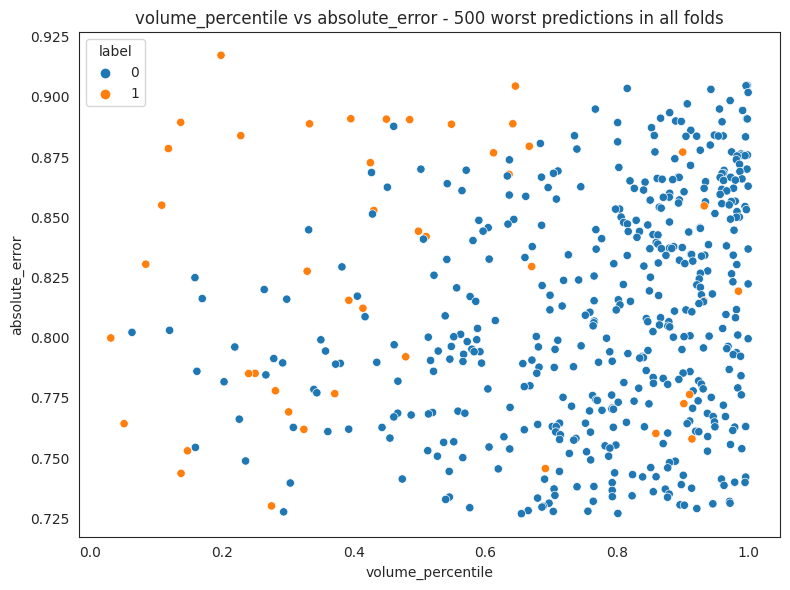

Scatterplot saved to //workspace/figures/error_volume_scatterplot_200_worst_predictions_in_fold_1.png
Worst predictions saved to //workspace/figures/200_worst_predictions_in_fold_1.csv


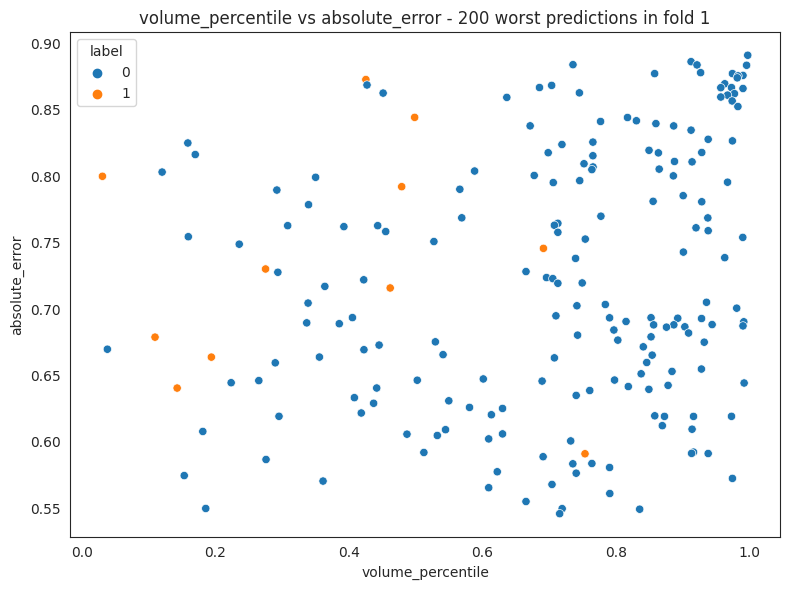

Scatterplot saved to //workspace/figures/error_volume_scatterplot_200_worst_predictions_in_fold_2.png
Worst predictions saved to //workspace/figures/200_worst_predictions_in_fold_2.csv


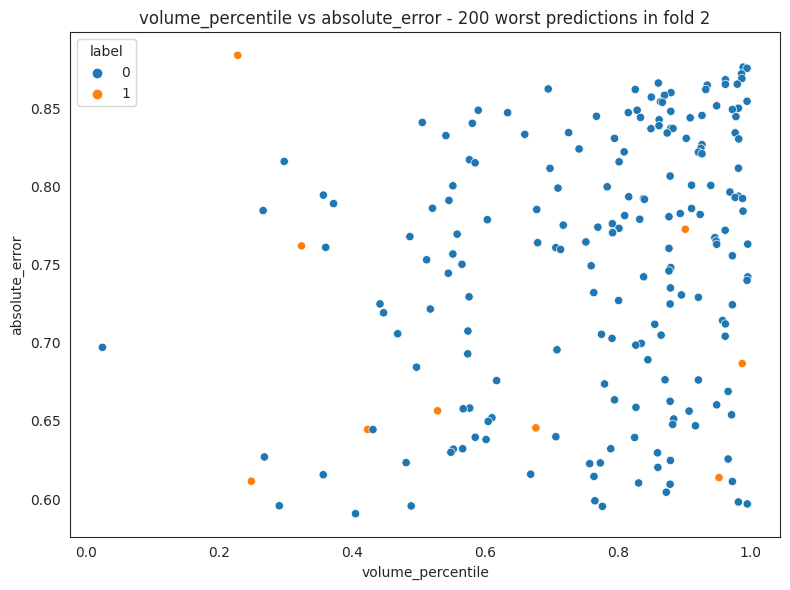

Scatterplot saved to //workspace/figures/error_volume_scatterplot_200_worst_predictions_in_fold_3.png
Worst predictions saved to //workspace/figures/200_worst_predictions_in_fold_3.csv


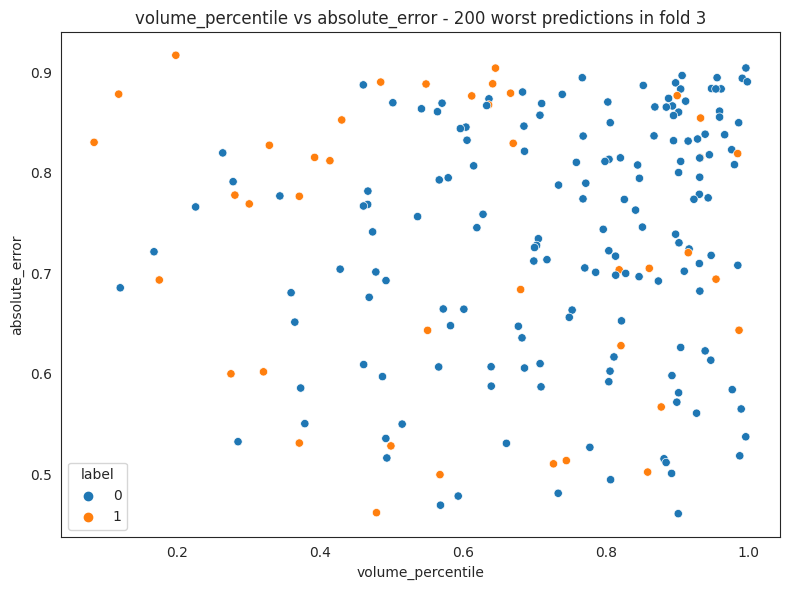

Scatterplot saved to //workspace/figures/error_volume_scatterplot_200_worst_predictions_in_fold_4.png
Worst predictions saved to //workspace/figures/200_worst_predictions_in_fold_4.csv


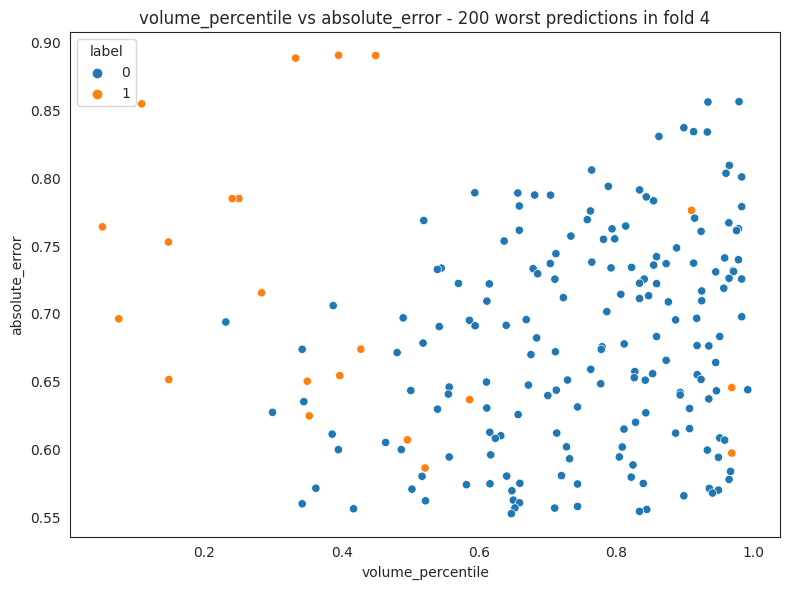

Scatterplot saved to //workspace/figures/error_volume_scatterplot_200_worst_predictions_in_fold_5.png
Worst predictions saved to //workspace/figures/200_worst_predictions_in_fold_5.csv


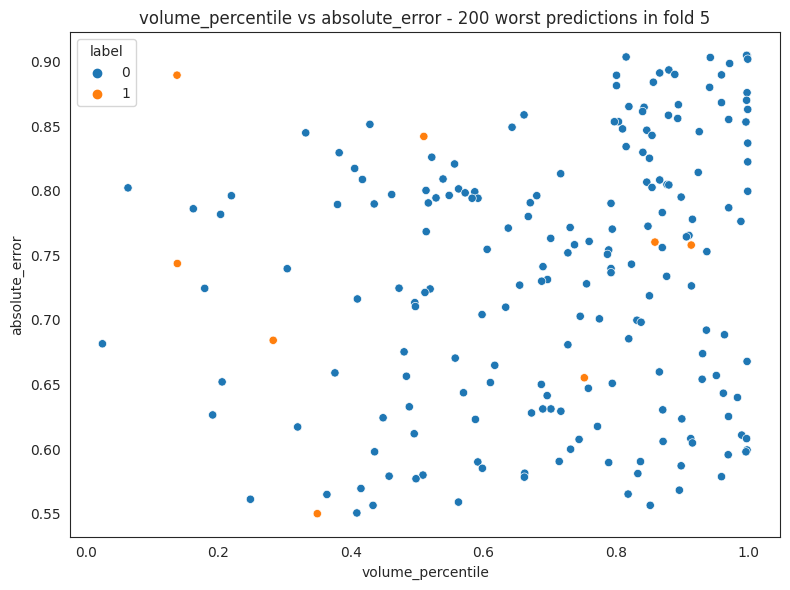

In [9]:
def plot_error_volume_distribution(df, num_worst_predictions=None, plot_label="all folds", save_plot=True, save_worst_predictions=True):
    plt.figure(figsize=(8, 6))

    df_plot = df.copy()
    if num_worst_predictions is not None:
        df_plot.sort_values(by=["absolute_error"], ascending=False, inplace=True)
        df_plot = df_plot[["AnnotationID", "label", "volume_percentile", "sphere_radius_mm", "absolute_error"]]
        df_plot = df_plot.head(num_worst_predictions)
        plot_label = f"{num_worst_predictions} worst predictions in {plot_label}"

    sns.scatterplot(data=df_plot, x="volume_percentile", y="absolute_error", hue="label")
    plt.title(f"volume_percentile vs absolute_error - {plot_label}")
    plt.xlabel("volume_percentile")
    plt.ylabel("absolute_error")
    
    plt.tight_layout()
    if save_plot:
        save_path = figures_dir / f"error_volume_scatterplot_{plot_label.replace(' ', '_')}.png"
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Scatterplot saved to {save_path}")
    if save_worst_predictions and num_worst_predictions is not None:
        save_path = figures_dir / f"{plot_label.replace(' ', '_')}.csv"
        df_plot.to_csv(save_path, index=False)
        print(f"Worst predictions saved to {save_path}")
    plt.show()

num_worst_predictions_all_folds = 500
num_worst_predictions_one_fold = 200
# plot_histogram_by_column(df_annotations_volumes_predictions, column_to_plot="absolute_error", column_to_label="fold", use_top_95th_percentile=False, bins=10)
plot_error_volume_distribution(df_annotations_volumes_predictions)
plot_error_volume_distribution(df_annotations_volumes_predictions, num_worst_predictions=num_worst_predictions_all_folds)
for fold in range(1, 6):
    df_fold = df_annotations_volumes_predictions[df_annotations_volumes_predictions["fold"] == fold]
    plot_error_volume_distribution(df_fold, num_worst_predictions=num_worst_predictions_one_fold, plot_label=f"fold {fold}")

### Edge Cases

0.8 quantile of sphere_radius_mm in all folds is 6.43831875260839


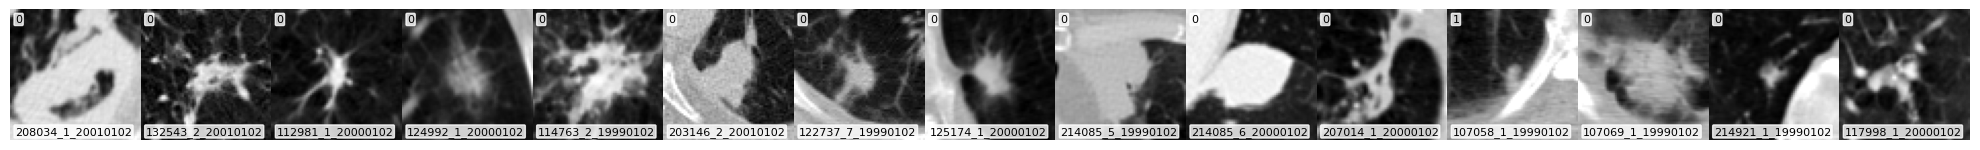

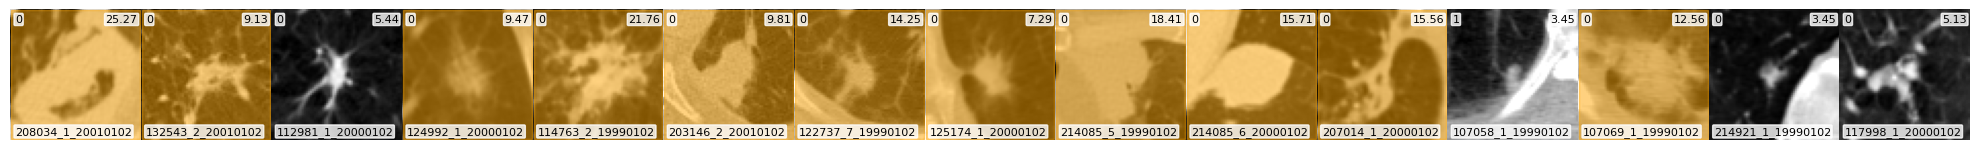

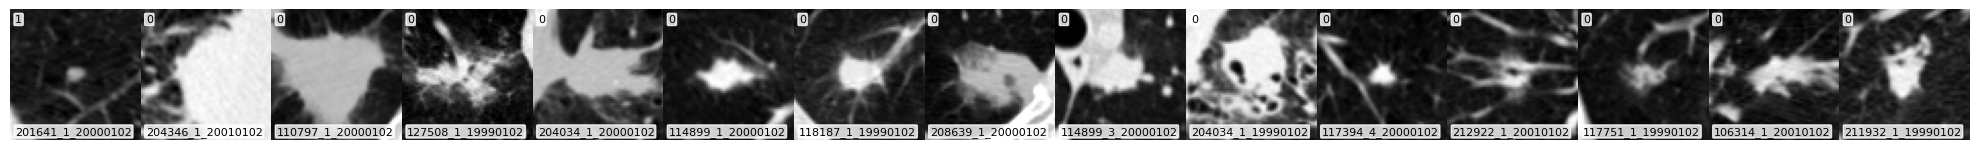

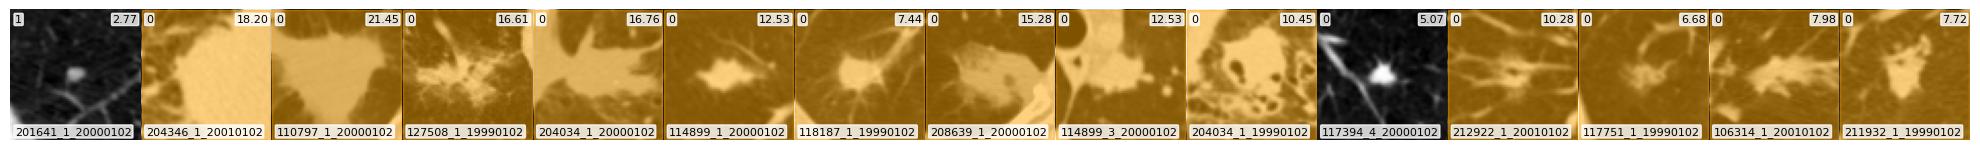

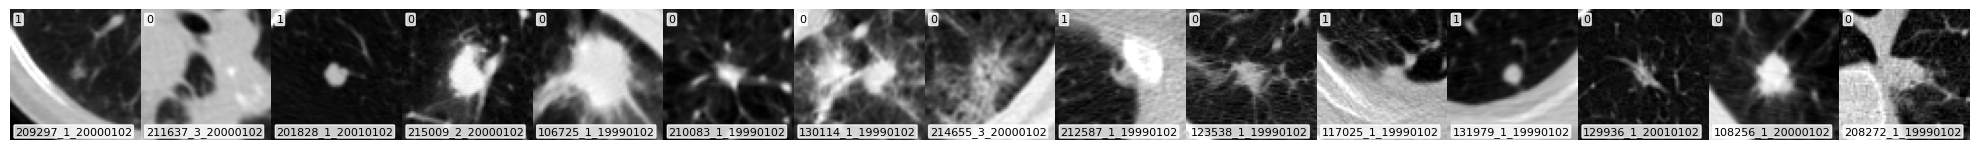

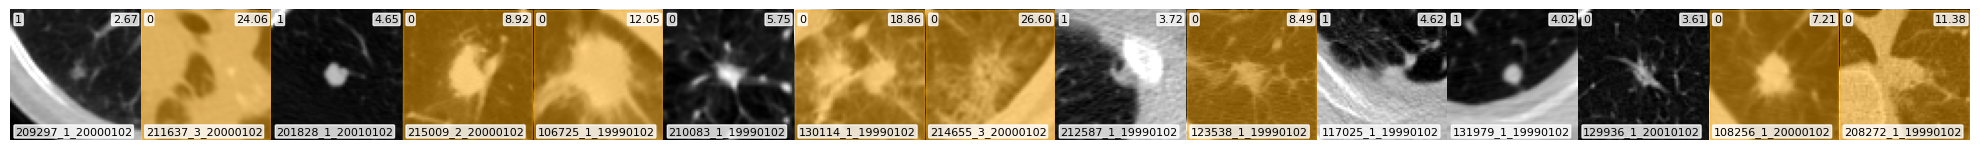

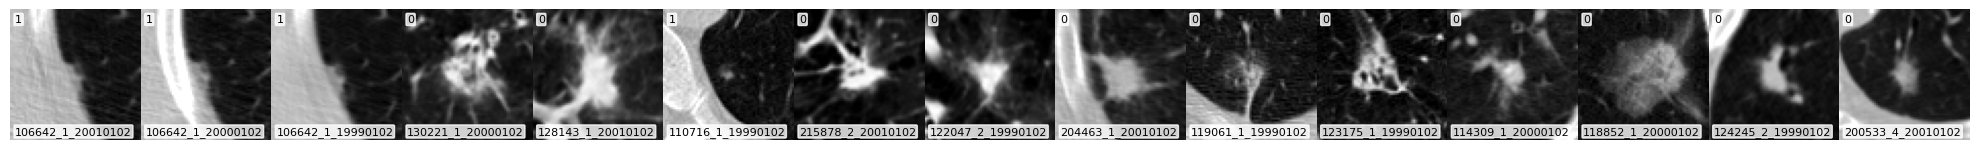

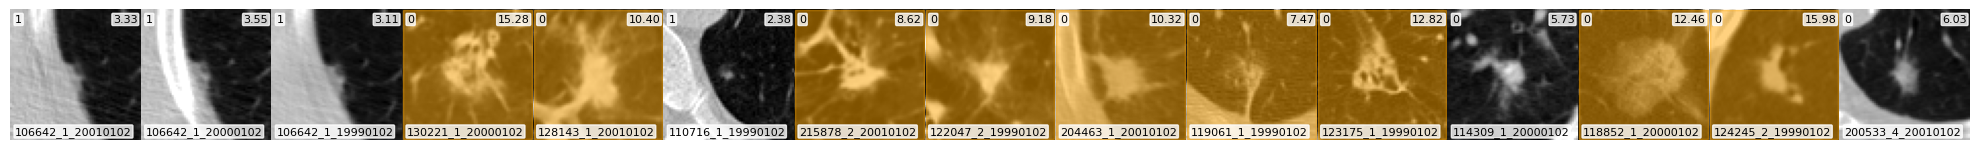

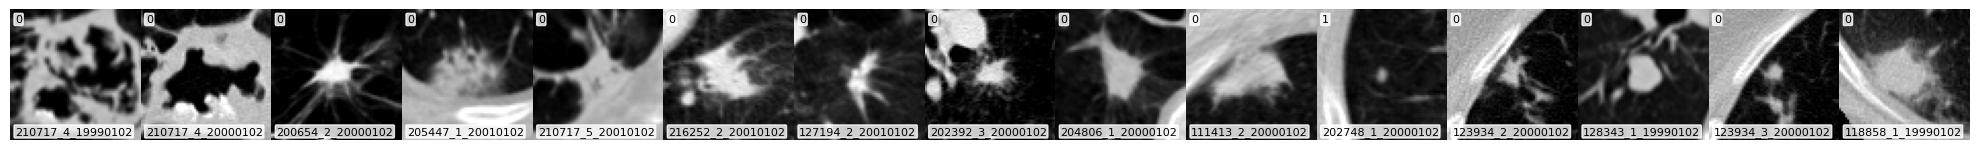

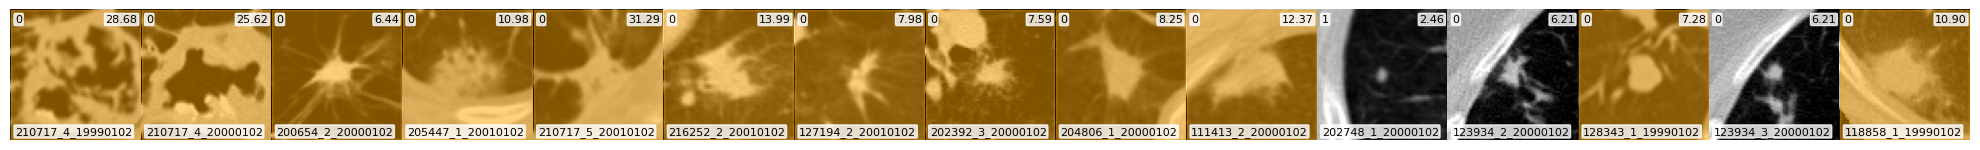

In [10]:
def plot_images(images, labels=None, annotation_ids=None, radius_mms=None, radius_mm_at_quantile=None, save_plot=True, plot_label=None):
    num_images, height, width = images.shape
    fig, axes = plt.subplots(1, num_images, figsize=(20, 3))
    for i, (ax, image) in enumerate(zip(axes, images)):
        ax.imshow(image, cmap="gray")

        bbox = dict(facecolor="white", alpha=0.8, boxstyle="round,pad=0.1")
        if labels is not None:
            ax.text(2, 2, f"{labels[i]}", fontsize=8, color="black", ha="left", va="top", bbox=bbox)
        if annotation_ids is not None:
            ax.text(2, height - 2, f"{annotation_ids[i]}", fontsize=8, color="black", ha="left", va="bottom", bbox=bbox)
        if radius_mms is not None:
            ax.text(width - 2, 2, f"{radius_mms[i]:.2f}", fontsize=8, color="black", ha="right", va="top", bbox=bbox)
            if radius_mm_at_quantile is not None and radius_mms[i] > radius_mm_at_quantile:
                rect_patch = Rectangle((0, 0), width - 1, height - 1, linewidth=1.0, edgecolor="orange", facecolor="orange", alpha=0.5, transform=ax.transData) 
                ax.add_patch(rect_patch)
        ax.axis("off")
    plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0, hspace=0)
    if save_plot:
        plt.savefig(figures_dir / f"{num_images}_worst_predictions_{plot_label}.png", dpi=300, bbox_inches="tight", pad_inches=0)
    plt.show()

num_images = 15
radius_quantile = 0.8
radius_mm_at_quantile = df_annotations_volumes_predictions["sphere_radius_mm"].quantile(radius_quantile)
print(f"{radius_quantile} quantile of sphere_radius_mm in all folds is {radius_mm_at_quantile}")
for fold in range(1, 6):
    worst_preds_csv_path = figures_dir / f"{num_worst_predictions_one_fold}_worst_predictions_in_fold_{fold}.csv"
    df_worst_preds = pd.read_csv(worst_preds_csv_path)
    df_images = df_worst_preds.head(num_images)
    df_images = df_images[["AnnotationID", "label", "sphere_radius_mm"]]
    data_loader = get_data_loader(
        config.DATADIR,
        df_images,
        mode=config.MODE,
        workers=0,
        batch_size=num_images,
        rotations=None,
        translations=None,
        size_mm=config.SIZE_MM,
        size_px=config.SIZE_PX,
    )
    for data in data_loader:
        images, labels, annotation_ids = data["image"].numpy(), data["label"].squeeze().numpy().tolist(), data["ID"]
        images = images[:, 0, images.shape[2] // 2, :, :]
        radius_mms = df_images[df_images.AnnotationID.isin(annotation_ids)].sphere_radius_mm.values
        plot_images(images, labels, annotation_ids, plot_label=f"fold_{fold}_no_radius")
        plot_images(images, labels, annotation_ids, radius_mms, radius_mm_at_quantile, plot_label=f"fold_{fold}")

# Evaluate

In [11]:
# https://github.com/DIAGNijmegen/luna25-evaluation-public
def calculate_auc(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)

    # Bootstrapping for 95% confidence intervals
    n_bootstraps = 1000
    rng = np.random.RandomState(seed=42)
    bootstrapped_aucs = []

    for _ in range(n_bootstraps):
        # Resample the data
        indices = rng.choice(len(y_true), len(y_true), replace=True)
        if len(np.unique(y_true.iloc[indices])) < 2:
            # Skip this resample if only one class is present
            continue
        score = roc_auc_score(y_true.iloc[indices], y_pred.iloc[indices])
        bootstrapped_aucs.append(score)

    # Calculate the confidence intervals
    ci_lower = np.percentile(bootstrapped_aucs, 2.5)
    ci_upper = np.percentile(bootstrapped_aucs, 97.5)

    return {"auc": auc, "ci_lower": ci_lower, "ci_upper": ci_upper}

def calculate_sensitivity(y_true, y_pred):
    """
    Computes the sensitivity (recall) at 95% specificity for a classifier.
    
    Parameters:
        y_true (array-like): Ground truth binary labels (0 = benign, 1 = malignant).
        y_pred (array-like): Predicted probability scores from the classifier.

    Returns:
        float: Sensitivity (recall) at 95% specificity.
        float: Decision threshold used to achieve 95% specificity.
    """
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    # Find the threshold corresponding to 95% specificity (FPR = 1 - specificity)
    target_fpr = 1 - 0.95  # 5% false positive rate
    idx = np.where(fpr <= target_fpr)[0][-1]  # Get the last index where FPR <= 5%
    
    # Extract sensitivity (TPR) and threshold
    sensitivity = tpr[idx]

    return {"sensitivity": sensitivity}

def calculate_specificity(y_true, y_pred):
    """
    Computes the specificity at 95% sensitivity for a classifier.
    
    Parameters:
        y_true (array-like): Ground truth binary labels (0 = benign, 1 = malignant).
        y_pred (array-like): Predicted probability scores from the classifier.

    Returns:
        float: Specificity at 95% sensitivity.
        float: Decision threshold used to achieve 95% sensitivity.
    """
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    
    # Find the threshold corresponding to 95% sensitivity (TPR = 0.95)
    target_tpr = 0.95  # Sensitivity (TPR) threshold
    idx = np.where(tpr >= target_tpr)[0][0]  # Get first index where TPR >= 95%
    
    # Extract specificity (1 - FPR) and threshold
    specificity = 1 - fpr[idx]
    
    return {"specificity": specificity}

results = {"Fold": [], "AUC": [], "Sensitivity": [], "Specificity": []}
for fold in range(1, 6):
    df_fold = df_annotations_volumes_predictions[df_annotations_volumes_predictions["fold"] == fold]
    labels = df_fold["label"]
    preds = df_fold["probability"]
    results["Fold"].append(fold)
    results["AUC"].append(calculate_auc(labels, preds)["auc"])
    results["Sensitivity"].append(calculate_sensitivity(labels, preds)["sensitivity"])
    results["Specificity"].append(calculate_specificity(labels, preds)["specificity"])
results = pd.DataFrame(results)
display(results)
print(f"Avg AUC: {results['AUC'].mean():.4f}")
print(f"Avg Sensitivity: {results['Sensitivity'].mean():.2f}")
print(f"Avg Specificity: {results['Specificity'].mean():.2f}")


Fold       AUC  Sensitivity  Specificity
0     1  0.914645     0.469565     0.649001
1     2  0.893779     0.456140     0.676069
2     3  0.874612     0.435897     0.562037
3     4  0.883910     0.490385     0.633419
4     5  0.923956     0.580952     0.714932

Avg AUC: 0.8982
Avg Sensitivity: 0.49
Avg Specificity: 0.65
